In [26]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer

import seaborn as sns
import matplotlib.pyplot as plt

In [95]:
df_train = pd.read_parquet('./data/fhv_tripdata_2021-01.parquet')
df_val = pd.read_parquet('./data/fhv_tripdata_2021-02.parquet')

# Q1. Downloading the data
Read the data for January. How many records are there?

In [96]:
# ANSWER
len(df_train)

1154112

# Q2. Computing duration
What's the average trip duration in January?

In [97]:
# Check dtypes first
df_train.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                     float64
DOlocationID                     float64
SR_Flag                           object
Affiliated_base_number            object
dtype: object

In [98]:
df_train['duration'] = df_train.dropOff_datetime - df_train.pickup_datetime
df_train.duration = df_train.duration.apply(lambda td: td.total_seconds() / 60)

# For validation data
df_val['duration'] = df_val.dropOff_datetime - df_val.pickup_datetime
df_val.duration = df_val.duration.apply(lambda td: td.total_seconds() / 60)

In [99]:
# ANSWER
df_train.duration.mean()

19.1672240937939

## Data preparation
Check the distribution of the duration variable. There are some outliers.

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop?

<AxesSubplot:xlabel='duration'>

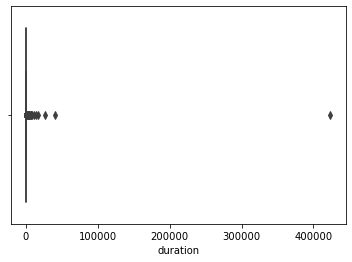

In [100]:
sns.boxplot(x = df_train.duration)

In [101]:
df_train = df_train[(df_train.duration >= 1) & (df_train.duration <=60)]

#For validation data
df_val = df_val[(df_val.duration >= 1) & (df_val.duration <=60)]

<AxesSubplot:xlabel='duration'>

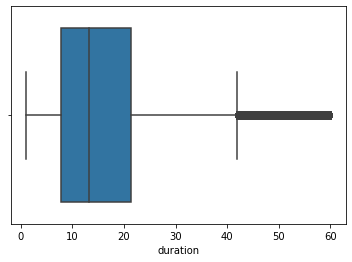

In [102]:
sns.boxplot(x = df_train.duration)

In [103]:
print(f'{1154112 - len(df_train)} rows dropped')

44286 rows dropped


# Q3. Missing values
The features we'll use for our model are the pickup and dropoff location IDs.

But they have a lot of missing values there. Let's replace them with "-1".

What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

In [104]:
print(f'PUlocationID has {df_train.PUlocationID.isna().sum()} missing values')
print(f'DOlocationID has {df_train.DOlocationID.isna().sum()} missing values')

PUlocationID has 927008 missing values
DOlocationID has 147907 missing values


In [105]:
df_train.PUlocationID = df_train.PUlocationID.fillna(-1)
df_train.DOlocationID = df_train.DOlocationID.fillna(-1)

# For validation data
df_val.PUlocationID = df_val.PUlocationID.fillna(-1)
df_val.DOlocationID = df_val.DOlocationID.fillna(-1)

In [106]:
print(f'PUlocationID has {df_train.PUlocationID.isna().sum()} missing values')
print(f'DOlocationID has {df_train.DOlocationID.isna().sum()} missing values')

PUlocationID has 0 missing values
DOlocationID has 0 missing values


In [107]:
# ANSWER
df_train.PUlocationID.value_counts()[-1] / len(df_train) * 100

83.52732770722618

# Q4. One-hot encoding
Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

* Turn the dataframe into a list of dictionaries
* Fit a dictionary vectorizer
* Get a feature matrix from it

What's the dimensionality of this matrix? (The number of columns).

In [112]:
categorical = ['PUlocationID','DOlocationID']
target = 'duration'

dv = DictVectorizer()

df_train[categorical] = df_train[categorical].astype(str)
train_dicts = df_train[categorical].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dicts)
y_train = df_train[target].values

df_val[categorical] = df_val[categorical].astype(str)
val_dicts = df_val[categorical].to_dict(orient = 'records')
X_val = dv.transform(val_dicts)
y_val = df_val[target].values

In [113]:
# ANSWER
print("Rows\tColumns")
X_train.shape

Rows	Columns


(1109826, 525)

# Q5. Training a model
Now let's use the feature matrix from the previous step to train a model.

* Train a plain linear regression model with default parameters
* Calculate the RMSE of the model on the training data

What's the RMSE on train?

In [114]:
lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

In [115]:
# ANSWER
mean_squared_error(y_train, y_pred, squared = False)

10.528519107206316

/home/zoomcampdataengineering/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zoomcampdataengineering/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


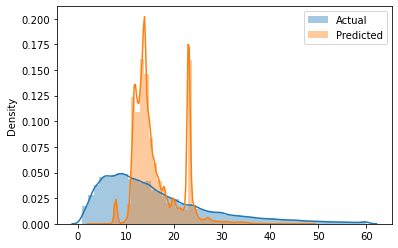

In [118]:
sns.distplot(y_train, label = 'Actual')
sns.distplot(y_pred, label = 'Predicted')

plt.legend()

# Q6. Evaluating the model
Now let's apply this model to the validation dataset (Feb 2021).

What's the RMSE on validation?

In [120]:
y_pred = lr.predict(X_val)

In [121]:
# ANSWER
mean_squared_error(y_val, y_pred, squared = False)

11.014283149347039

/home/zoomcampdataengineering/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zoomcampdataengineering/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


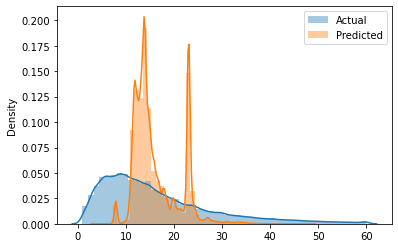

In [122]:
sns.distplot(y_train, label = 'Actual')
sns.distplot(y_pred, label = 'Predicted')

plt.legend()